In [2]:
# Libraries
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

In [3]:
# Path class
class_path = "data/EDIH 5 - třída 3 - 1_patro_vlevo - IAQ16_simplified.xlsx"

In [4]:
columns_to_keep = [
    "temp_sensor_time",
    "temp_sensor_avg",
    "humidity_avg",
    "co2_avg",
    "pressure_avg"]

class_df = pd.read_excel(class_path, sheet_name=0)[columns_to_keep]
class_df = class_df.dropna()
class_df["temp_sensor_time"] = pd.to_datetime(class_df["temp_sensor_time"], format="%Y-%m-%dT%H:%M:%S", errors="coerce")
class_df.head()

,temp_sensor_time,temp_sensor_avg,humidity_avg,co2_avg,pressure_avg
0,2025-03-31 23:08:53,22.78,34.44,680.0,98142.0
1,2025-03-31 22:38:53,22.84,34.78,736.0,98126.0
2,2025-03-31 22:08:53,22.90,35.07,777.0,98106.0
4,2025-03-31 21:03:53,22.95,35.35,825.0,98050.0
5,2025-03-31 20:33:53,22.95,35.31,834.0,98019.0


In [5]:
#Distribution by time
#Months
class_df["month"] = class_df["temp_sensor_time"].dt.to_period("M")
valid_months = class_df["month"].value_counts()
valid_months = valid_months[valid_months >= 10].index.sort_values()
n_vmouths = len(valid_months)
months = class_df["month"].sort_values().unique()

#Hours
class_df["hour"] = class_df["temp_sensor_time"].dt.hour

#Days
class_df["dayofweek"] = class_df["temp_sensor_time"].dt.dayofweek
nameofdays = ["Po", "Út", "St", "Čt", "Pá", "So", "Ne"]

In [6]:
#Limits
max_temp_norm = 22
min_temp_norm = 20

max_hum_norm = 70
min_hum_norm = 30

#max_ilum1_norm = 200
#max_ilum2_norm = 50

co21 = 1000
co22 = 1500
co23 = 2000

In [7]:
# EDIH Style
line_color = "#5D5FEF"
min_line_color = "#3BAA5A"
max_line_color = "#E4572E"
background_color = "#F9FAFB"
bar_color = "#5D5FEF"
grid_color = "#D8DBF8"
highlight_above = "#F59E9E"  # red (overlimit)
highlight_below = "#A1CFFF"  # blue (underlimit)

Temperature

In [8]:
class_df[["temp_sensor_avg","humidity_avg","co2_avg","pressure_avg"]].describe().round(3)

,temp_sensor_avg,humidity_avg,co2_avg,pressure_avg
count,7183.000,7183.000,7183.000,7183.000
mean,20.412,49.561,1053.823,97704.675
std,1.135,4.455,429.927,1048.599
min,16.410,32.430,486.000,94468.000
25%,19.570,47.760,768.000,96971.500
50%,20.210,50.180,954.000,97875.000
75%,21.175,52.090,1188.500,98531.000
max,24.360,60.080,3779.000,99880.000


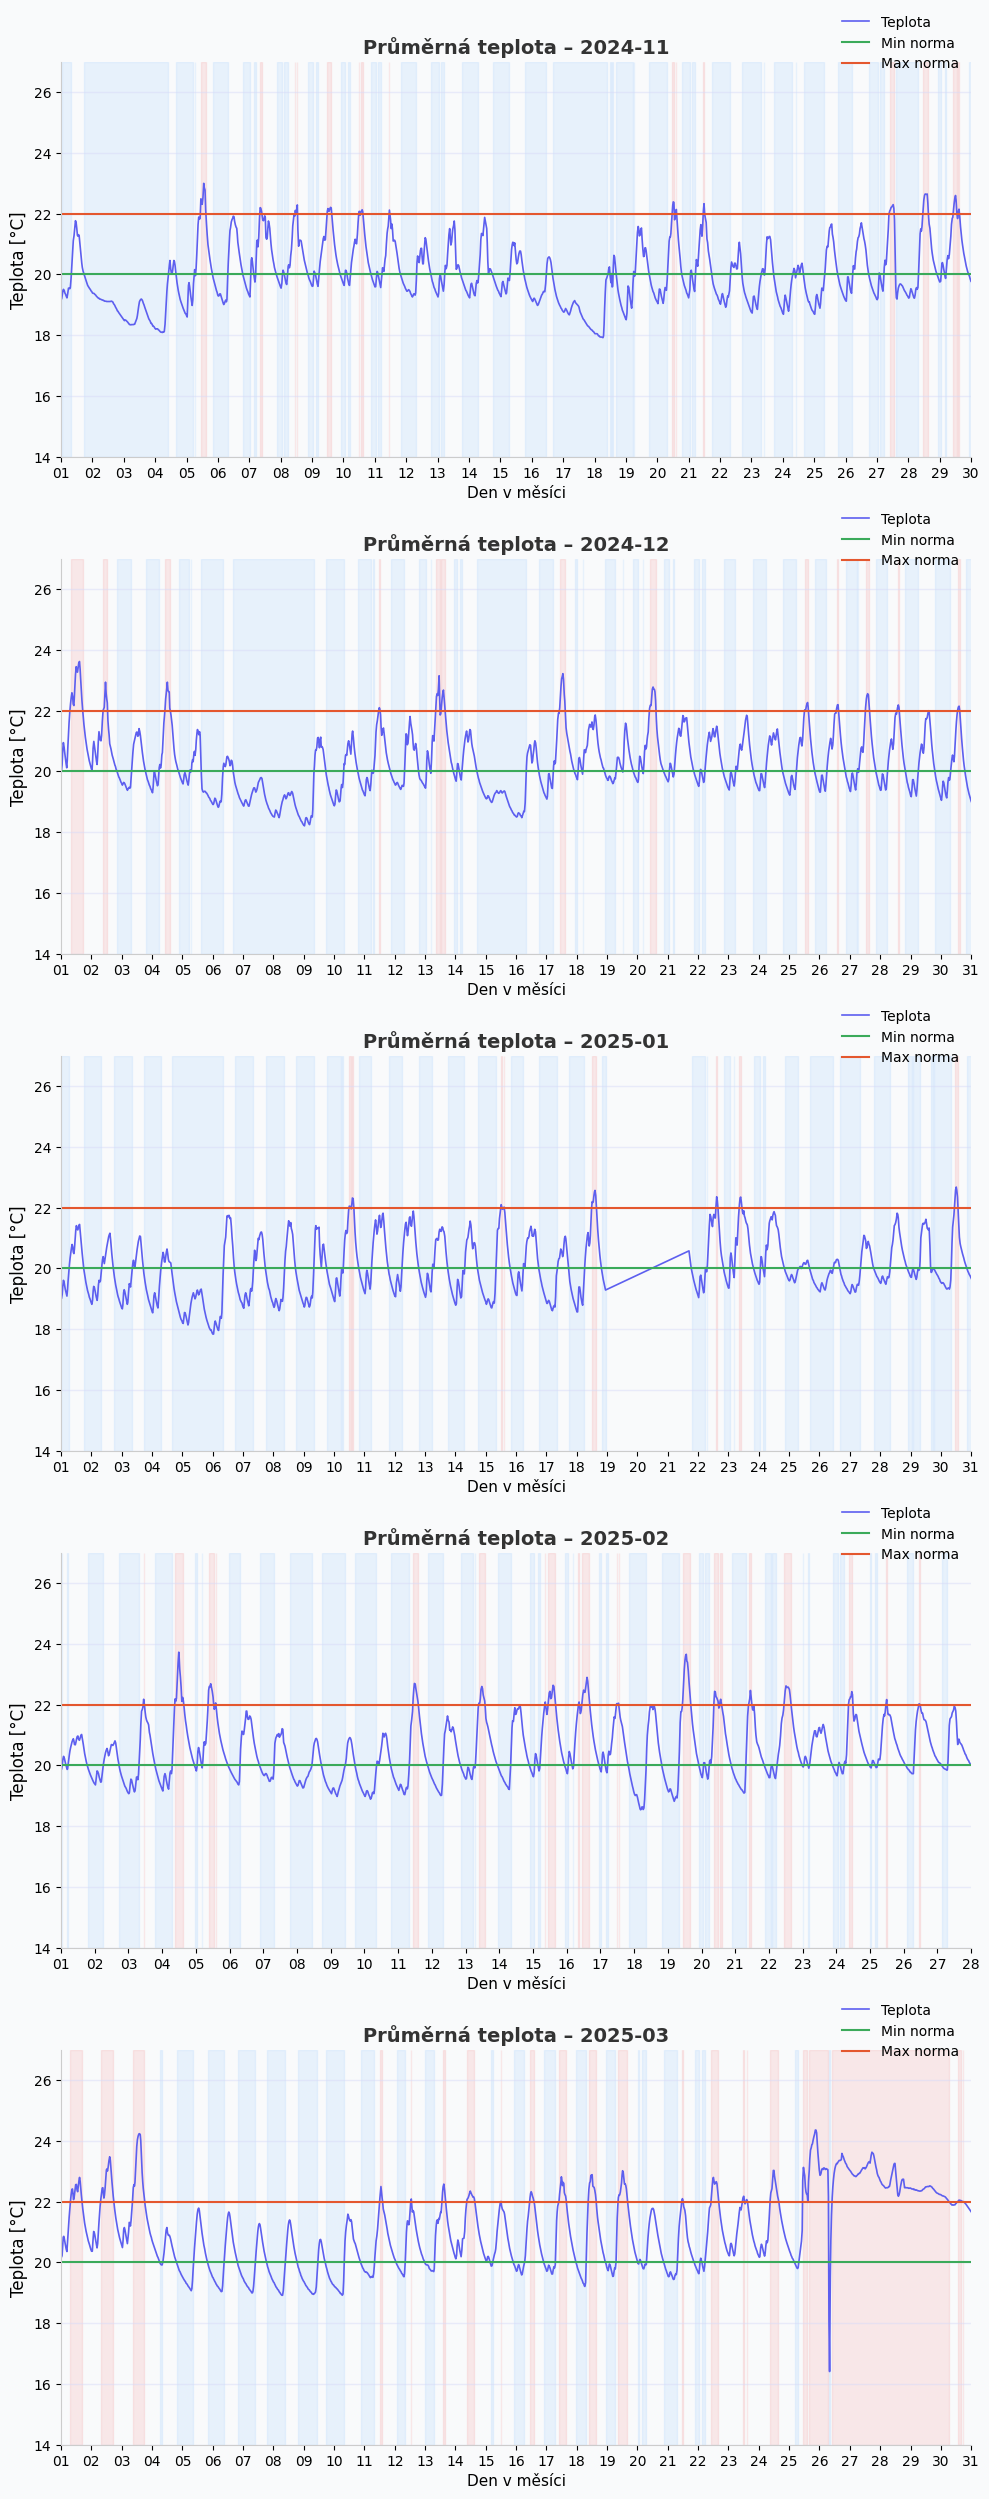

In [26]:
# Plotting the graph
fig_temp_01, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10, (5*n_vmouths)), sharey=True, facecolor=background_color)
axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

for i, one_month in enumerate(valid_months):
    df_month = class_df[class_df["month"] == one_month].copy()

    # Exceeding the limit
    df_month["OverLimit"] = df_month["temp_sensor_avg"] > max_temp_norm
    df_month["UnderLimit"] = df_month["temp_sensor_avg"] < min_temp_norm
    df_month["GroupOver"] = (df_month["OverLimit"] != df_month["OverLimit"].shift()).cumsum()
    df_month["GroupUnder"] = (df_month["UnderLimit"] != df_month["UnderLimit"].shift()).cumsum()


    ax = axes[i]
    ax.set_facecolor(background_color)

    # Time series
    ax.plot(df_month["temp_sensor_time"], df_month["temp_sensor_avg"],
            label="Teplota", color=line_color, linewidth=1.2)

    # Limits
    ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

 # Highlighting limit exceedance
    for _, group in df_month[df_month["OverLimit"]].groupby("GroupOver"):
        start = group["temp_sensor_time"].min()
        end = group["temp_sensor_time"].max()
        ax.axvspan(start, end, color=highlight_above, alpha=0.2)

    for _, group in df_month[df_month["UnderLimit"]].groupby("GroupUnder"):
        start = group["temp_sensor_time"].min()
        end = group["temp_sensor_time"].max()
        ax.axvspan(start, end, color=highlight_below, alpha=0.2)

    # Titles and axis
    ax.set_title(f"Průměrná teplota – {one_month}", fontsize=14, weight='bold', color="#333333")
    ax.set_ylabel("Teplota [°C]", fontsize=12)
    ax.set_xlabel("Den v měsíci", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # X-axis format
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))

    # Cut X axis
    one_month_str = str(one_month)
    xmin = pd.to_datetime(f"{one_month_str}-01")
    xmax = xmin + pd.offsets.MonthEnd(0)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(14, 27)

    # Grid and borders
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_temp_01)

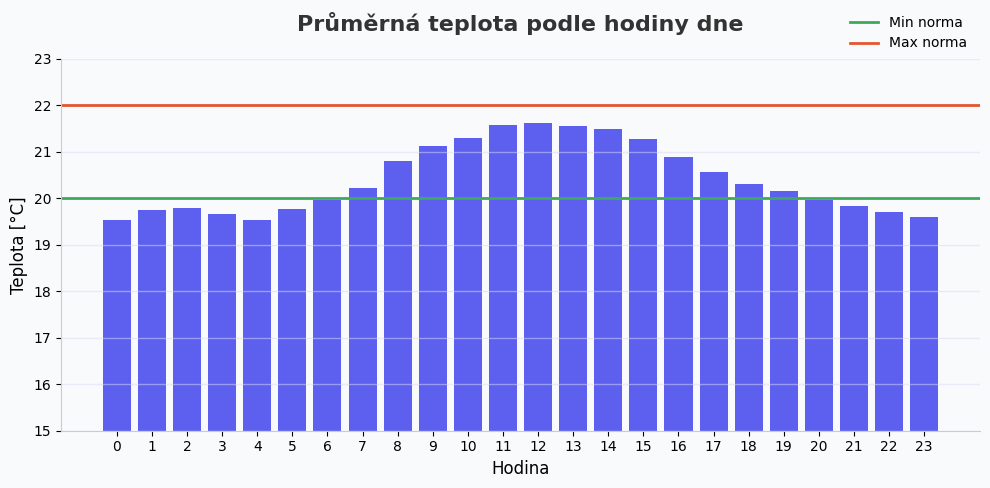

In [10]:
# Calculation of average temperature by hour
hourly_avg = class_df.groupby("hour")["temp_sensor_avg"].mean()

# Plotting the graph
fig_temp_02, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Columns
ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

# Limits
ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=2, label="Min norma")
ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma")

# Titles and axes
ax.set_title("Průměrná teplota podle hodiny dne", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Hodina", fontsize=12)
ax.set_ylabel("Teplota [°C]", fontsize=12)
ax.set_xticks(range(0, 24))
ax.set_ylim(15, 23)
ax.tick_params(axis='both', labelsize=10)

# Grid
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

# Frames and styling
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_temp_02)

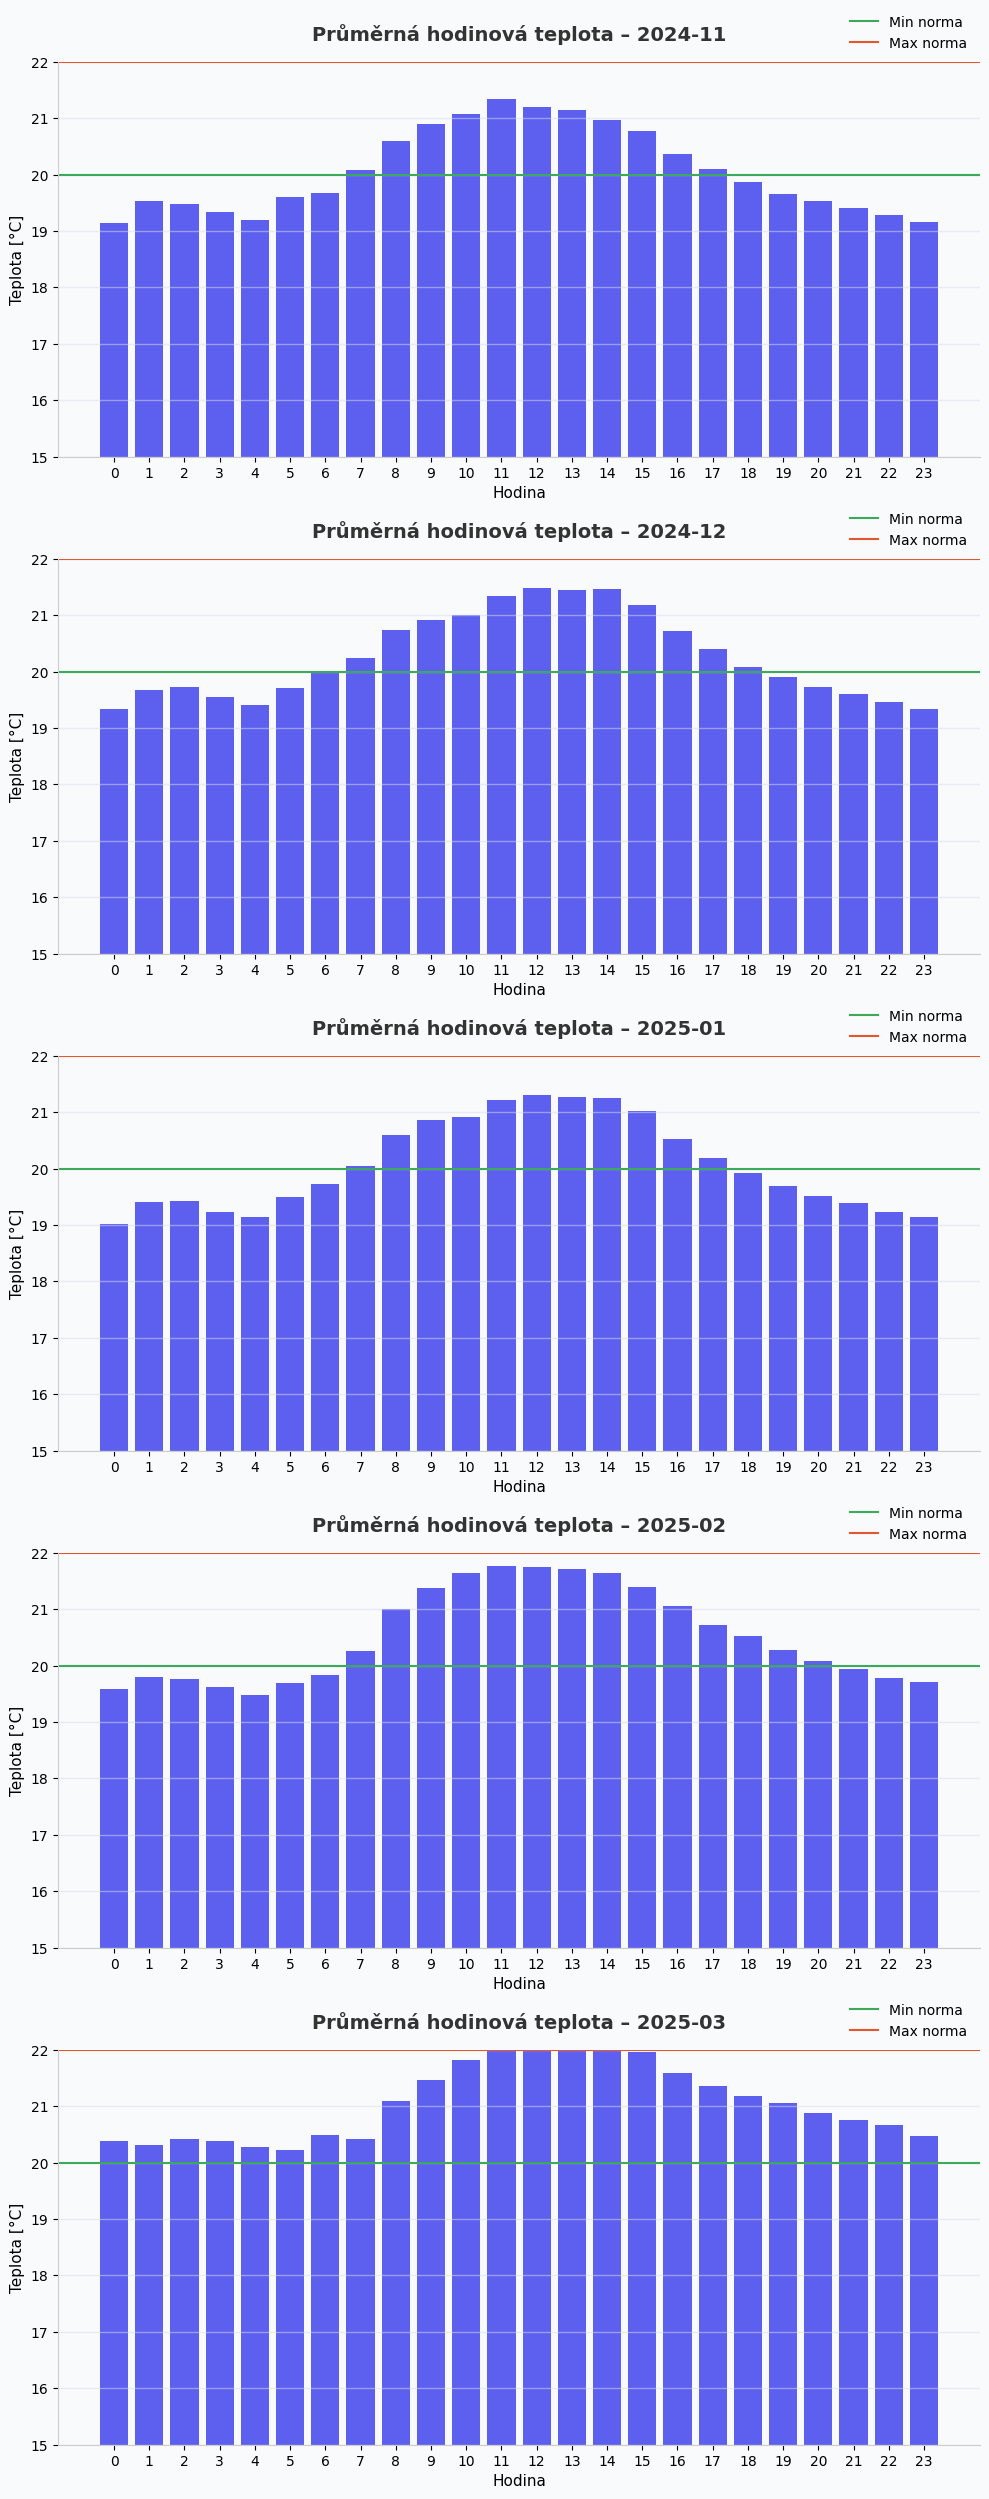

In [11]:
# Plotting the graph
fig_temp_03, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10,5*n_vmouths), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, one_month in enumerate(valid_months):
    df_month = class_df[class_df["month"] == one_month]
    hourly_avg = df_month.groupby("hour")["temp_sensor_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Columns
    ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

    # Limits
    ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

    # Titles and axes
    ax.set_title(f"Průměrná hodinová teplota – {one_month}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Hodina", fontsize=11)
    ax.set_ylabel("Teplota [°C]", fontsize=11)
    ax.set_xticks(range(0, 24))
    ax.set_ylim(15, 22)
    ax.tick_params(axis='both', labelsize=10)

    # Grid
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

    # Frames and styling
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_temp_03)

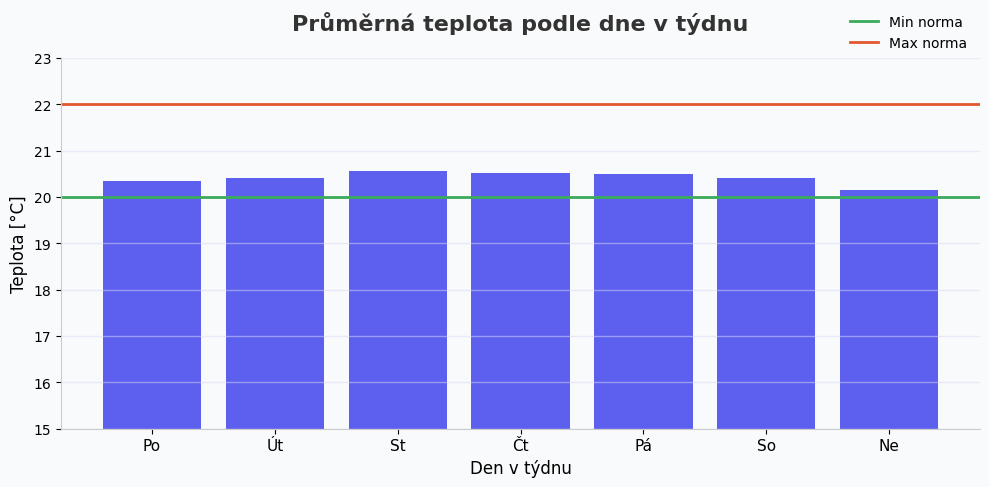

In [12]:
# Calculation of average temperature by day od the week
weekly_avg = class_df.groupby("dayofweek")["temp_sensor_avg"].mean()

# Plotting the graph
fig_temp_04, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Columns
ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

# Limits
ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=2, label="Min norma")
ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma")

# Titles and axes
ax.set_title("Průměrná teplota podle dne v týdnu", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Den v týdnu", fontsize=12)
ax.set_ylabel("Teplota [°C]", fontsize=12)
ax.set_xticks(range(7))
ax.set_xticklabels (nameofdays, fontsize=11)
ax.set_ylim(15, 23)
ax.tick_params(axis='y', labelsize=10)

# Frames and styling
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_temp_04)

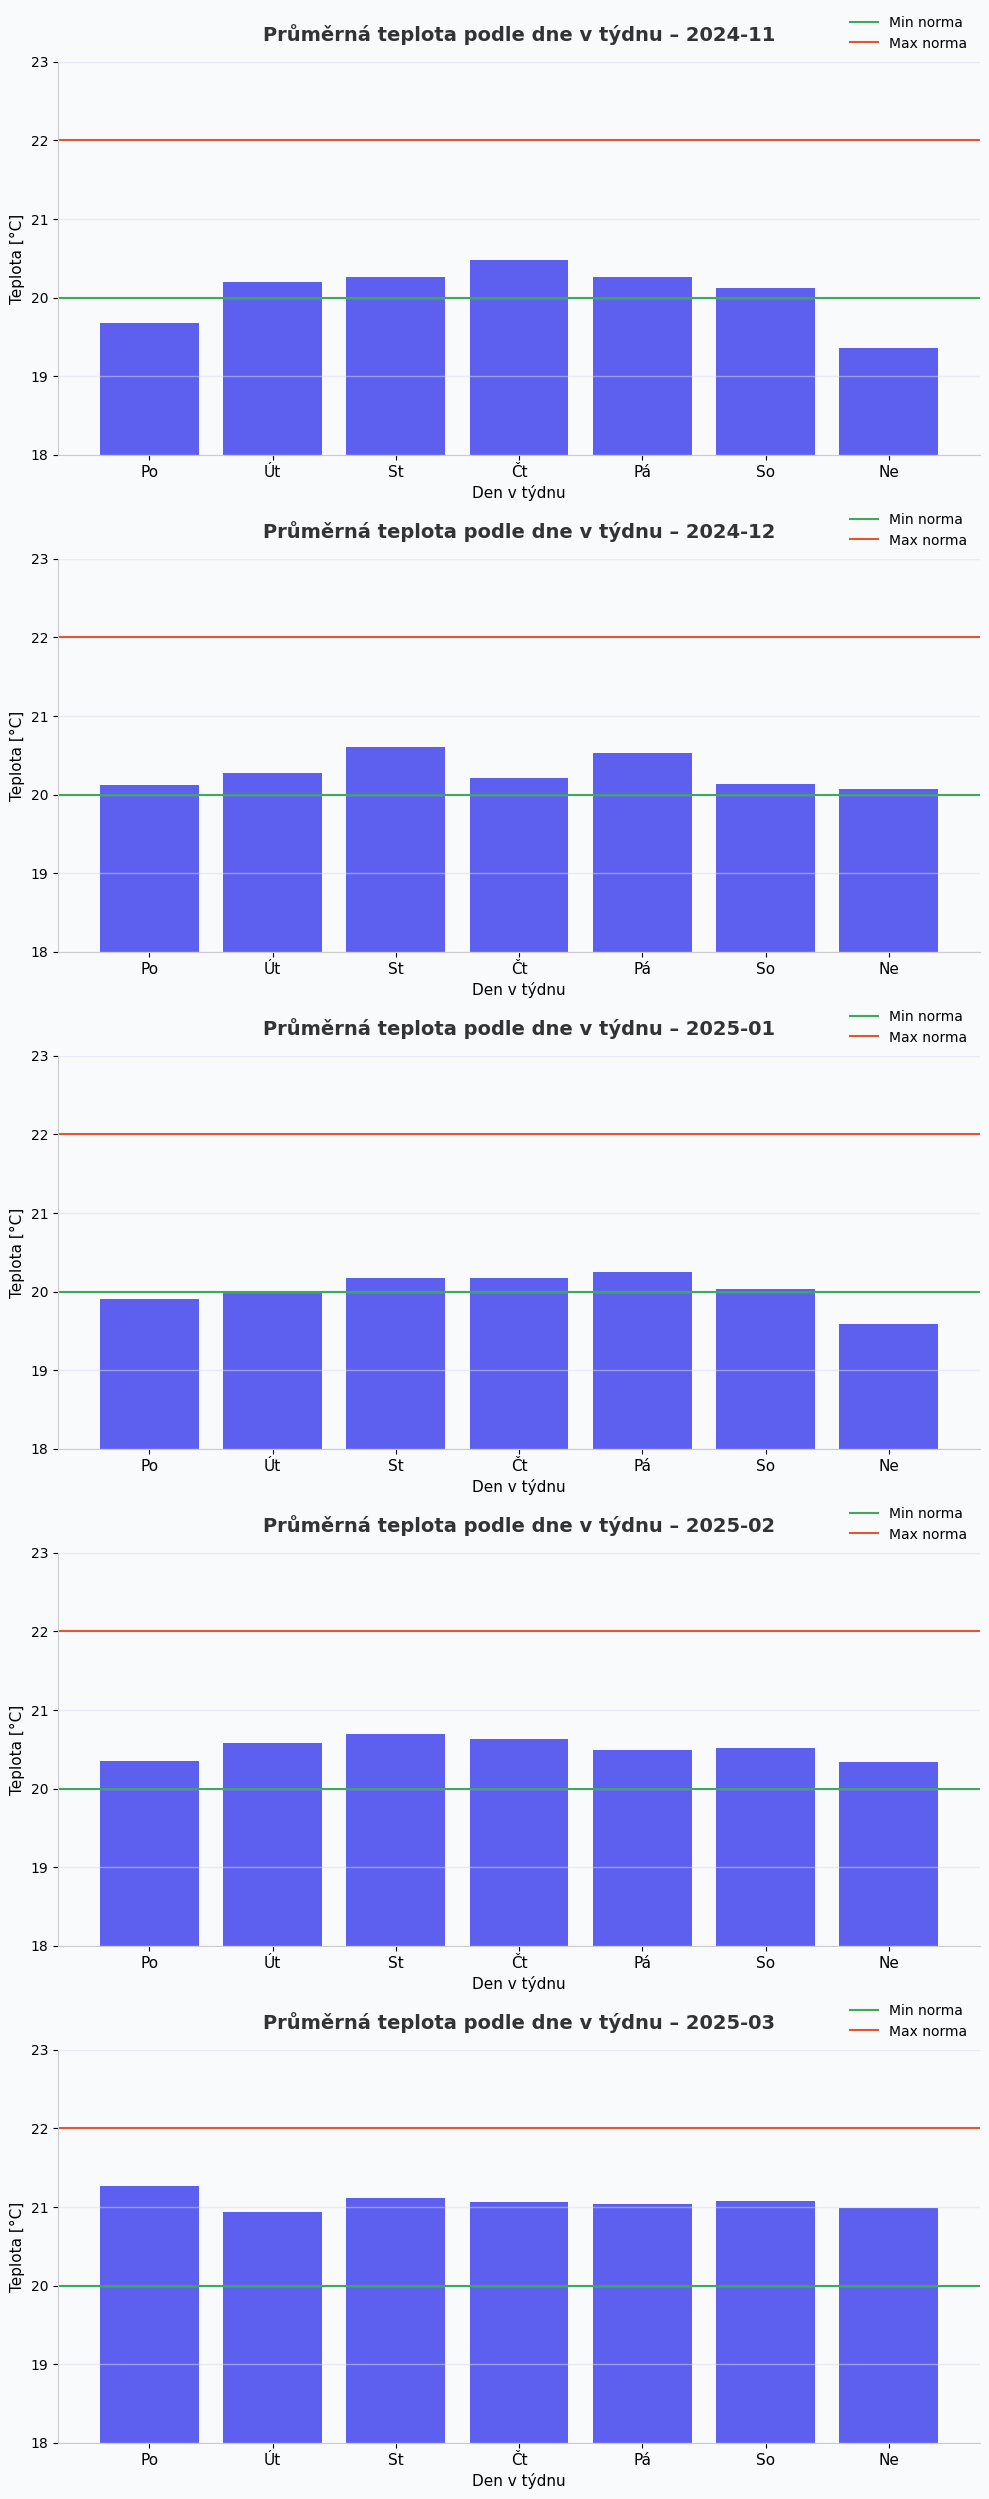

In [13]:
# Plotting the graph
fig_temp_05, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10, (5 * n_vmouths)), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, one_month in enumerate(valid_months):
    df_mesic = class_df[class_df["month"] == one_month]
    weekly_avg = df_mesic.groupby("dayofweek")["temp_sensor_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Columns
    ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

    # Limits
    ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

    # Titles and axes
    ax.set_title(f"Průměrná teplota podle dne v týdnu – {one_month}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Den v týdnu", fontsize=11)
    ax.set_ylabel("Teplota [°C]", fontsize=11)
    ax.set_xticks(range(7))
    ax.set_xticklabels(nameofdays, fontsize=11)
    ax.set_ylim(18, 23)
    ax.tick_params(axis='y', labelsize=10)

    # Frames and styling
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_temp_05)

Humidity

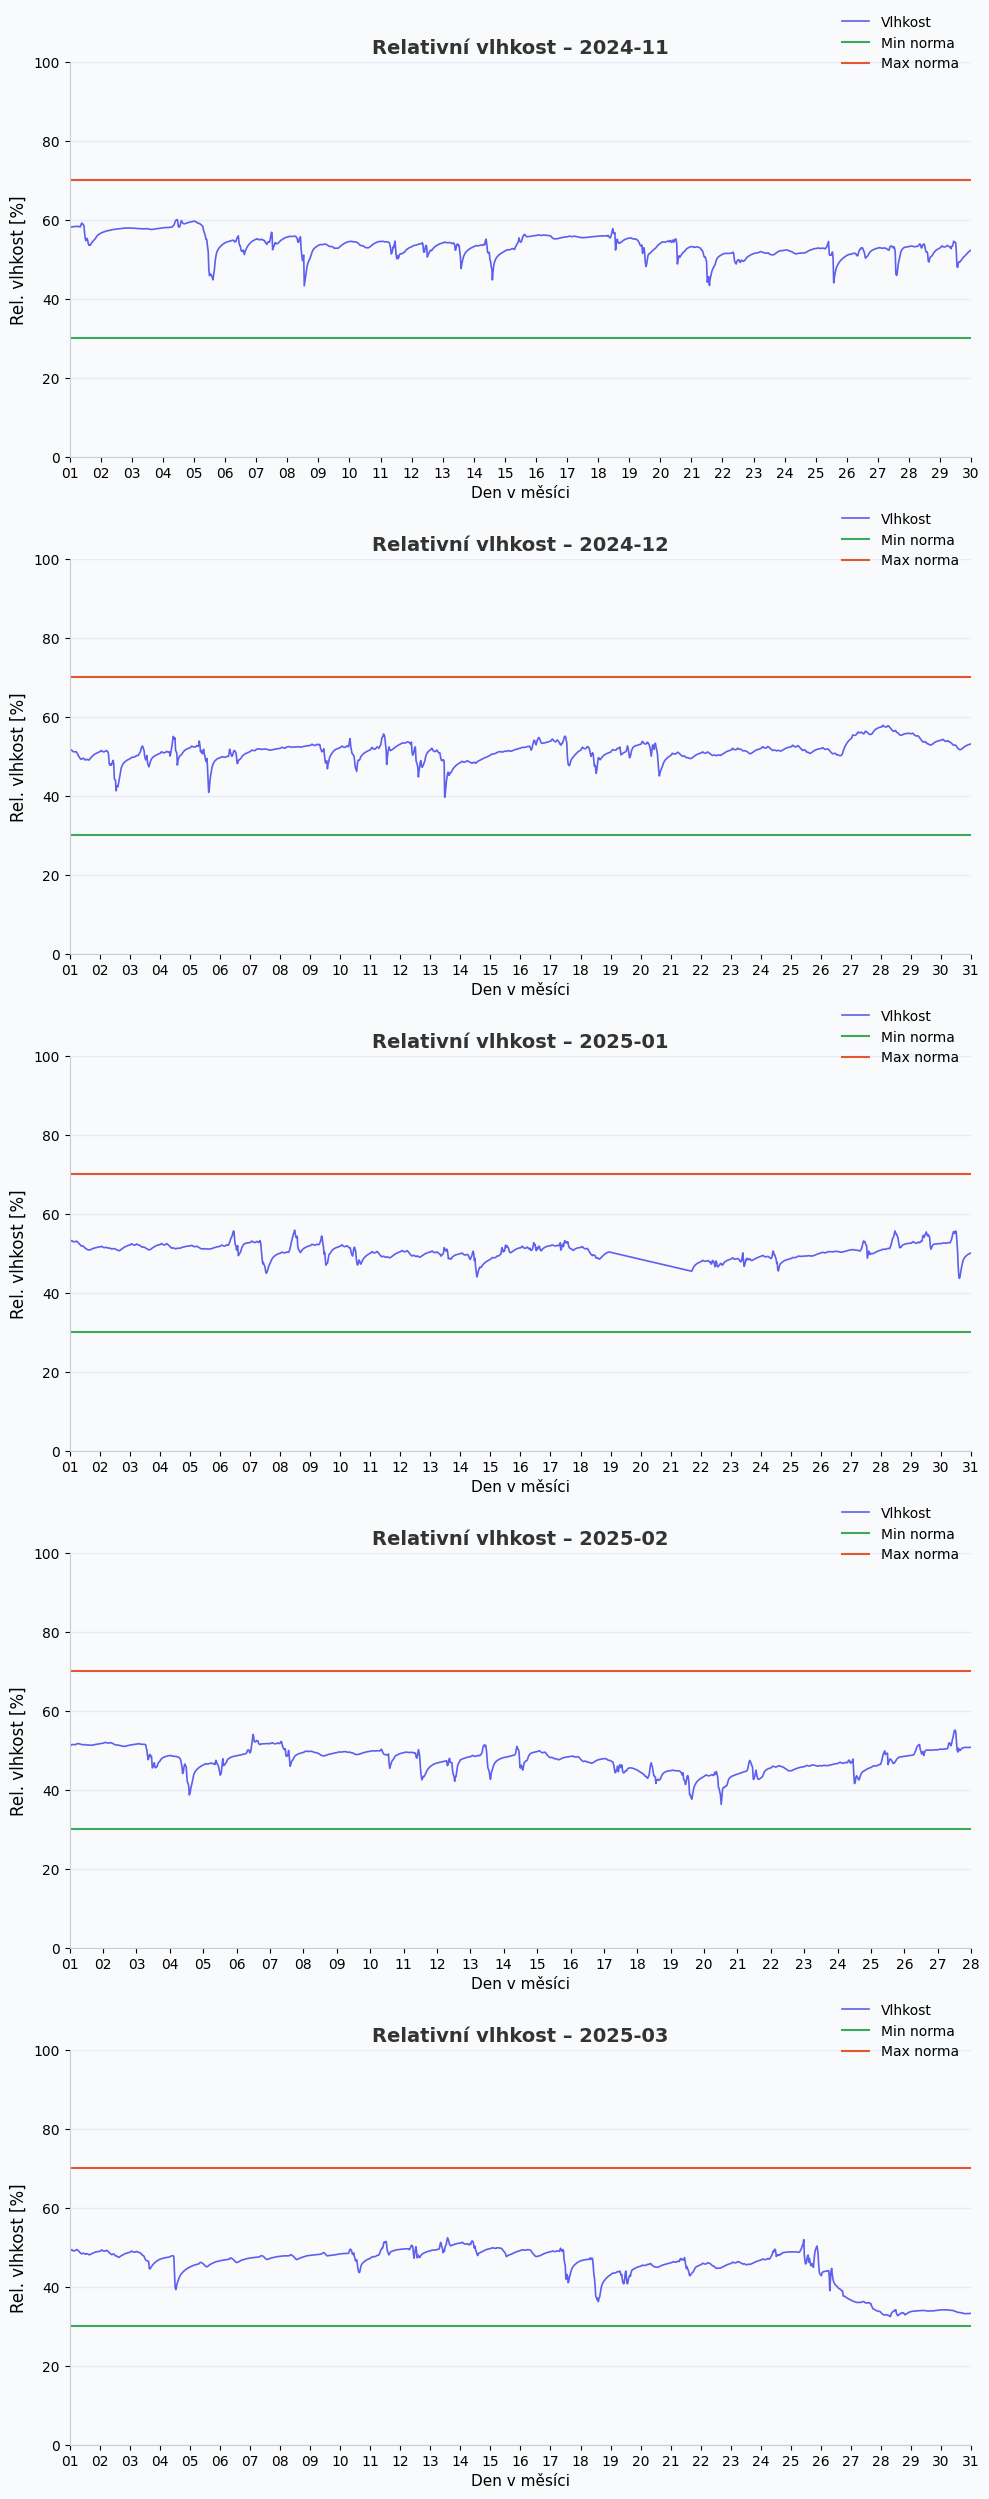

In [14]:
# Plotting the graph
fig_humi_01, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10, (5*n_vmouths)), sharey=True, facecolor=background_color)
axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

for i, one_month in enumerate(valid_months):
    df_month = class_df[class_df["month"] == one_month].copy()

    # Exceeding the limit
    df_month["OverLimit"] = df_month["humidity_avg"] > max_hum_norm
    df_month["UnderLimit"] = df_month["humidity_avg"] < min_hum_norm
    df_month["GroupOver"] = (df_month["OverLimit"] != df_month["OverLimit"].shift()).cumsum()
    df_month["GroupUnder"] = (df_month["UnderLimit"] != df_month["UnderLimit"].shift()).cumsum()


    ax = axes[i]
    ax.set_facecolor(background_color)

    # Time series
    ax.plot(df_month["temp_sensor_time"], df_month["humidity_avg"],
            label="Vlhkost", color=line_color, linewidth=1.2)

    # Limits
    ax.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

 # Highlighting limit exceedance
    for _, group in df_month[df_month["OverLimit"]].groupby("GroupOver"):
        start = group["temp_sensor_time"].min()
        end = group["temp_sensor_time"].max()
        ax.axvspan(start, end, color=highlight_above, alpha=0.2)

    for _, group in df_month[df_month["UnderLimit"]].groupby("GroupUnder"):
        start = group["temp_sensor_time"].min()
        end = group["temp_sensor_time"].max()
        ax.axvspan(start, end, color=highlight_below, alpha=0.2)

    # Titles and axis
    ax.set_title(f"Relativní vlhkost – {one_month}", fontsize=14, weight='bold', color="#333333")
    ax.set_ylabel("Rel. vlhkost [%]", fontsize=12)
    ax.set_xlabel("Den v měsíci", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # X-axis format
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))

    # Cut X axis
    one_month_str = str(one_month)
    xmin = pd.to_datetime(f"{one_month_str}-01")
    xmax = xmin + pd.offsets.MonthEnd(0)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(0, 100)

    # Grid and borders
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_temp_01)

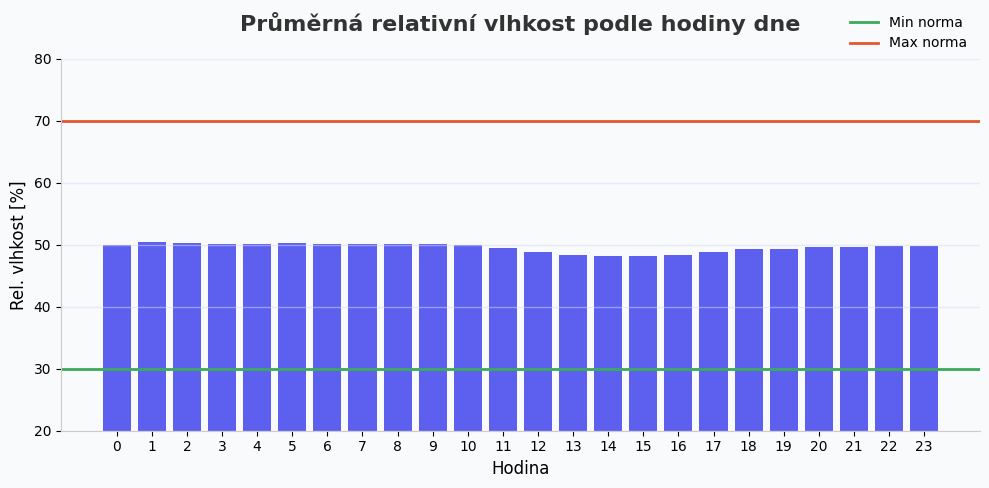

In [15]:
# Calculation of average temperature by hour
hourly_avg = class_df.groupby("hour")["humidity_avg"].mean()

# Plotting the graph
fig_humi_02, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Columns
ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

# Limits
ax.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=2, label="Min norma")
ax.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma")

# Titles and axes
ax.set_title("Průměrná relativní vlhkost podle hodiny dne", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Hodina", fontsize=12)
ax.set_ylabel("Rel. vlhkost [%]", fontsize=12)
ax.set_xticks(range(0, 24))
ax.set_ylim(20, 80)
ax.tick_params(axis='both', labelsize=10)

# Grid
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

# Frames and styling
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_humi_02)

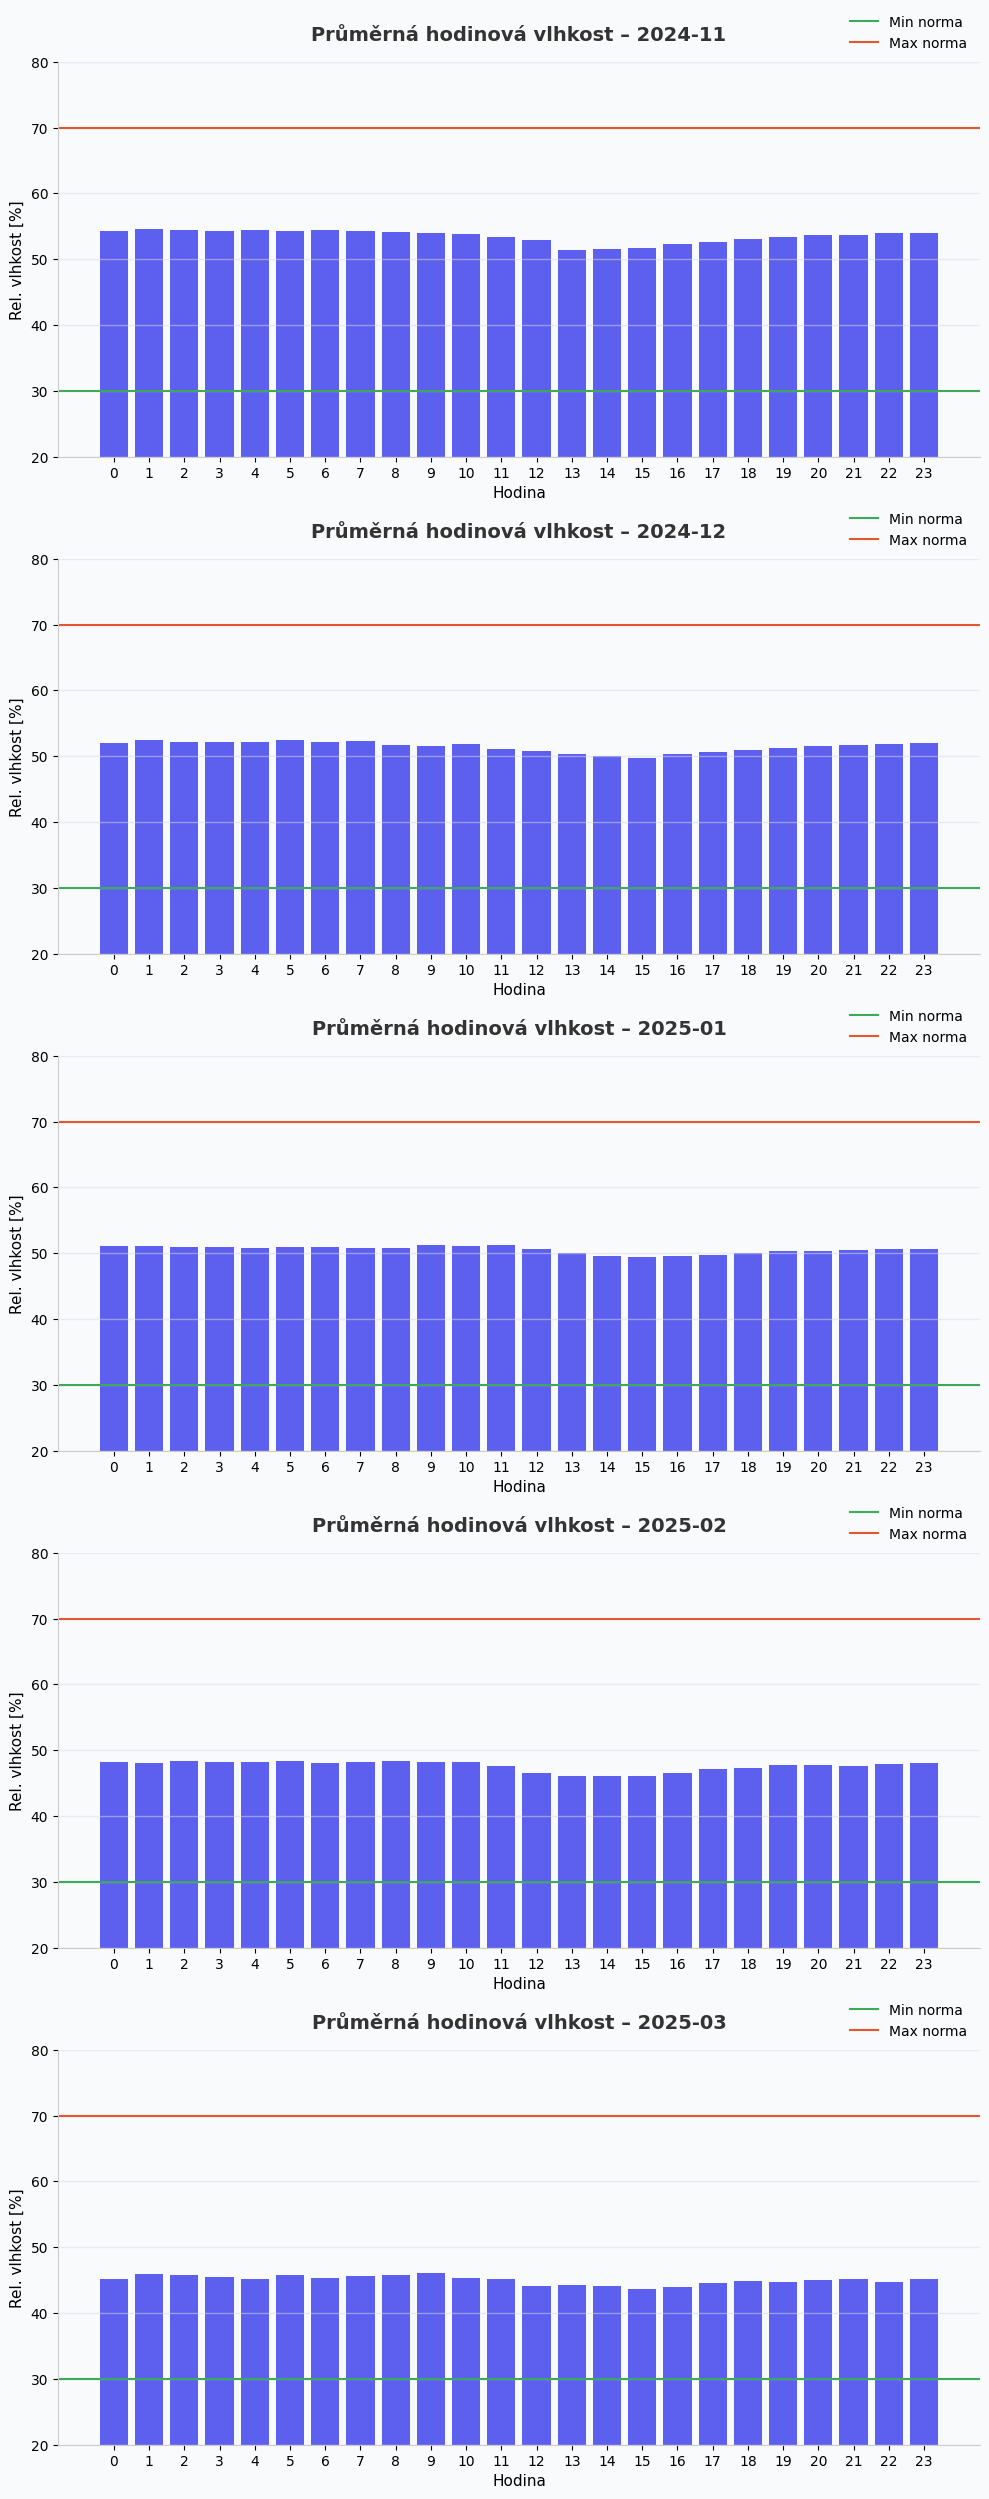

In [16]:
# Plotting the graph
fig_humi_03, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10,5*n_vmouths), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, one_month in enumerate(valid_months):
    df_month = class_df[class_df["month"] == one_month]
    hourly_avg = df_month.groupby("hour")["humidity_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Columns
    ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

    # Limits
    ax.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

    # Titles and axes
    ax.set_title(f"Průměrná hodinová vlhkost – {one_month}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Hodina", fontsize=11)
    ax.set_ylabel("Rel. vlhkost [%]", fontsize=11)
    ax.set_xticks(range(0, 24))
    ax.set_ylim(20, 80)
    ax.tick_params(axis='both', labelsize=10)

    # Grid
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

    # Frames and styling
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_humi_03)

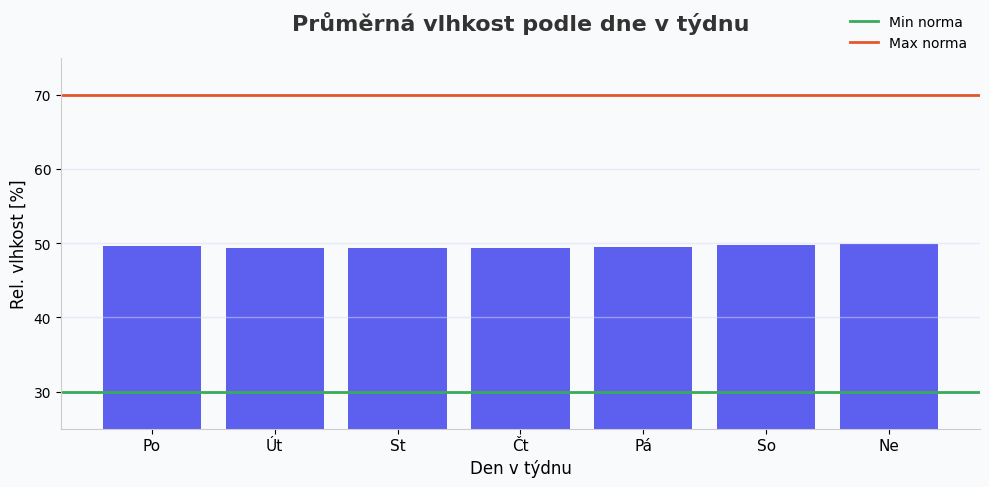

In [17]:
# Calculation of average temperature by day od the week
weekly_avg = class_df.groupby("dayofweek")["humidity_avg"].mean()

# Plotting the graph
fig_humi_04, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Columns
ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

# Limits
ax.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=2, label="Min norma")
ax.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma")

# Titles and axes
ax.set_title("Průměrná vlhkost podle dne v týdnu", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Den v týdnu", fontsize=12)
ax.set_ylabel("Rel. vlhkost [%]", fontsize=12)
ax.set_xticks(range(7))
ax.set_xticklabels (nameofdays, fontsize=11)
ax.set_ylim(25, 75)
ax.tick_params(axis='y', labelsize=10)

# Frames and styling
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_humi_04)

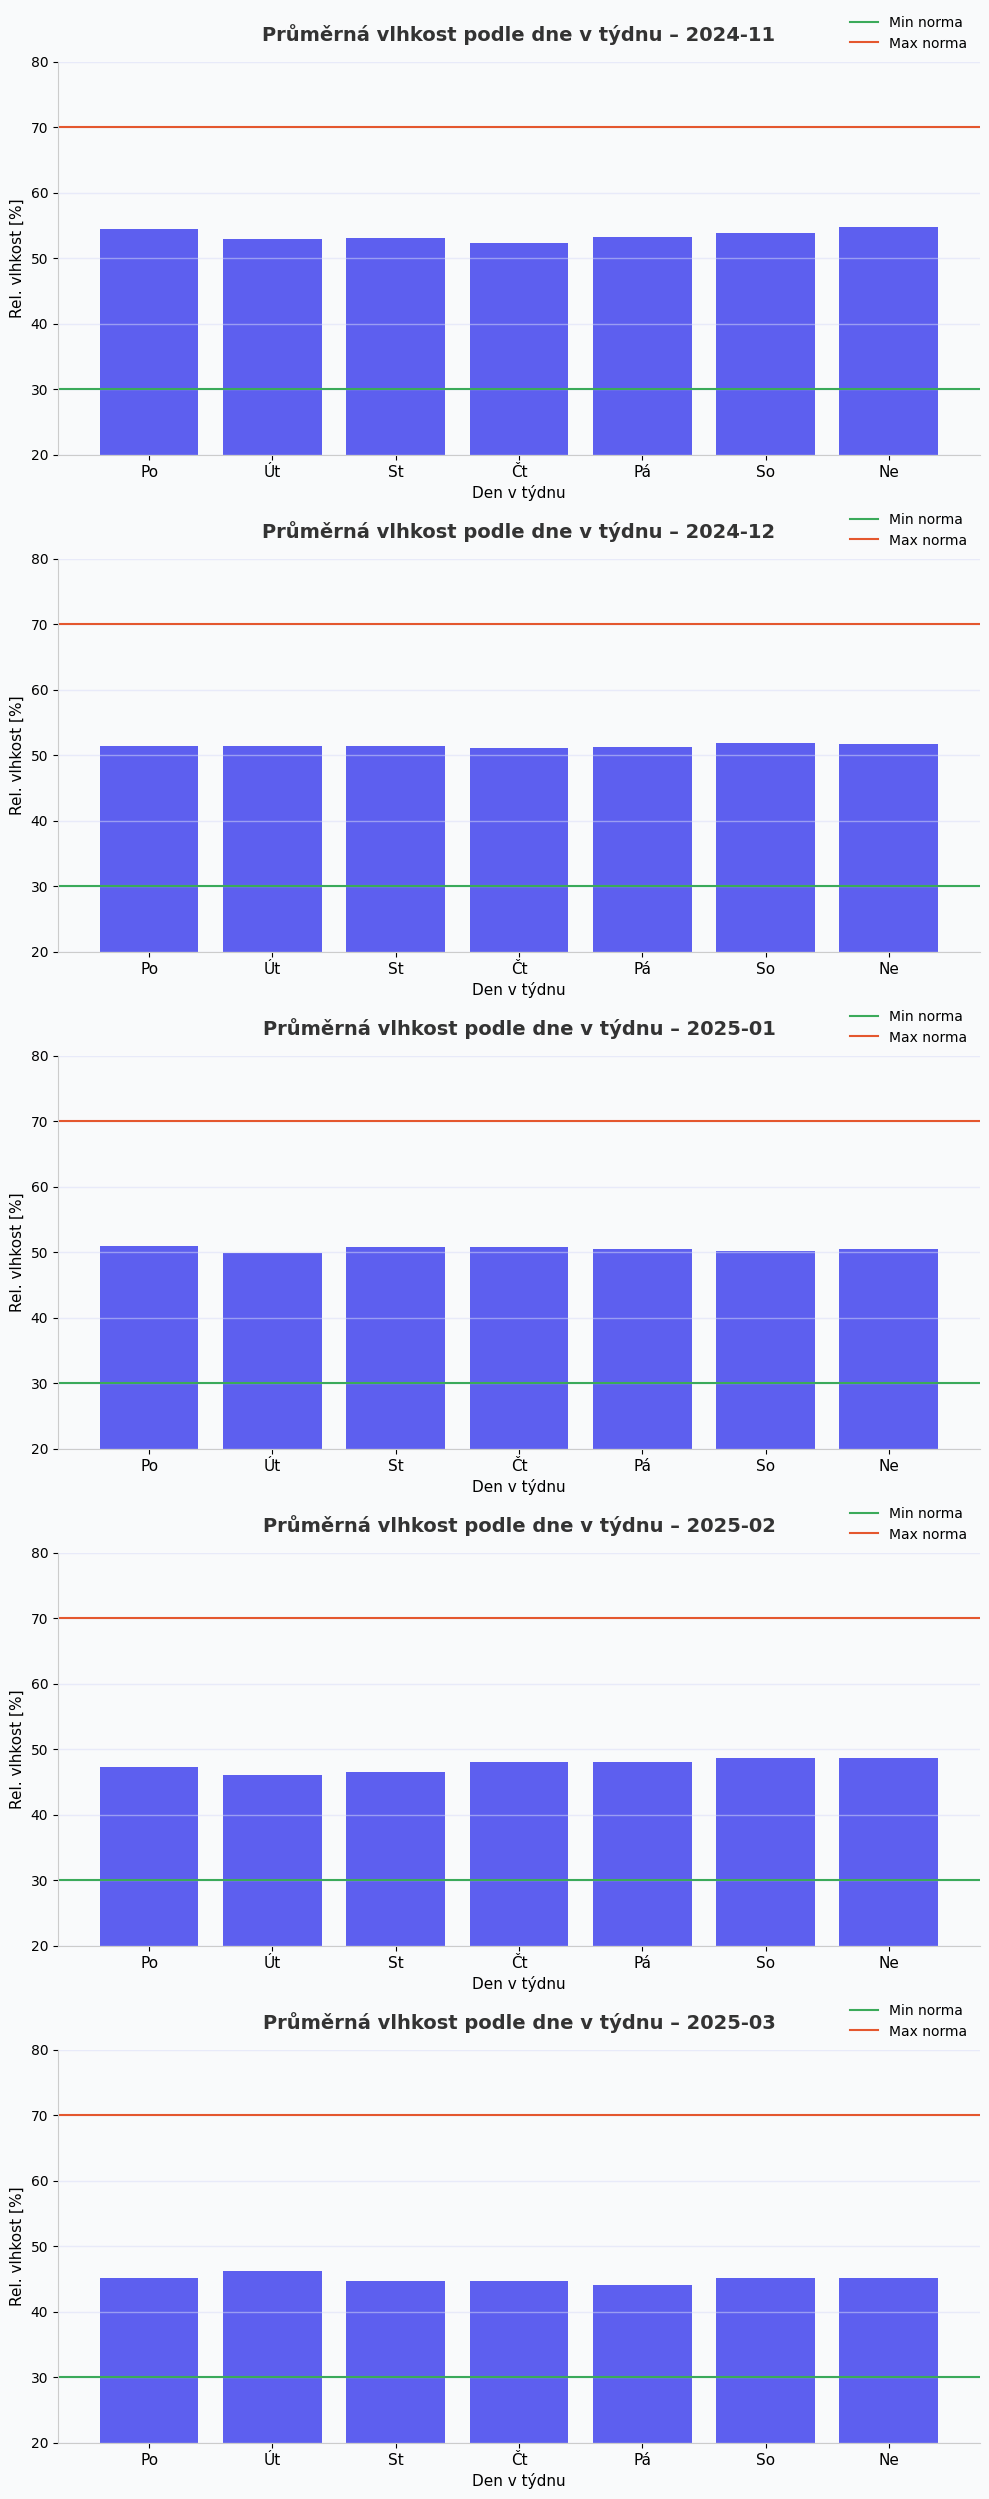

In [18]:
# Plotting the graph
fig_humi_05, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10, (5 * n_vmouths)), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, one_month in enumerate(valid_months):
    df_mesic = class_df[class_df["month"] == one_month]
    weekly_avg = df_mesic.groupby("dayofweek")["humidity_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Columns
    ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

    # Limits
    ax.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

    # Titles and axes
    ax.set_title(f"Průměrná vlhkost podle dne v týdnu – {one_month}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Den v týdnu", fontsize=11)
    ax.set_ylabel("Rel. vlhkost [%]", fontsize=11)
    ax.set_xticks(range(7))
    ax.set_xticklabels(nameofdays, fontsize=11)
    ax.set_ylim(20, 80)
    ax.tick_params(axis='y', labelsize=10)

    # Frames and styling
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_humi_05)

CO2

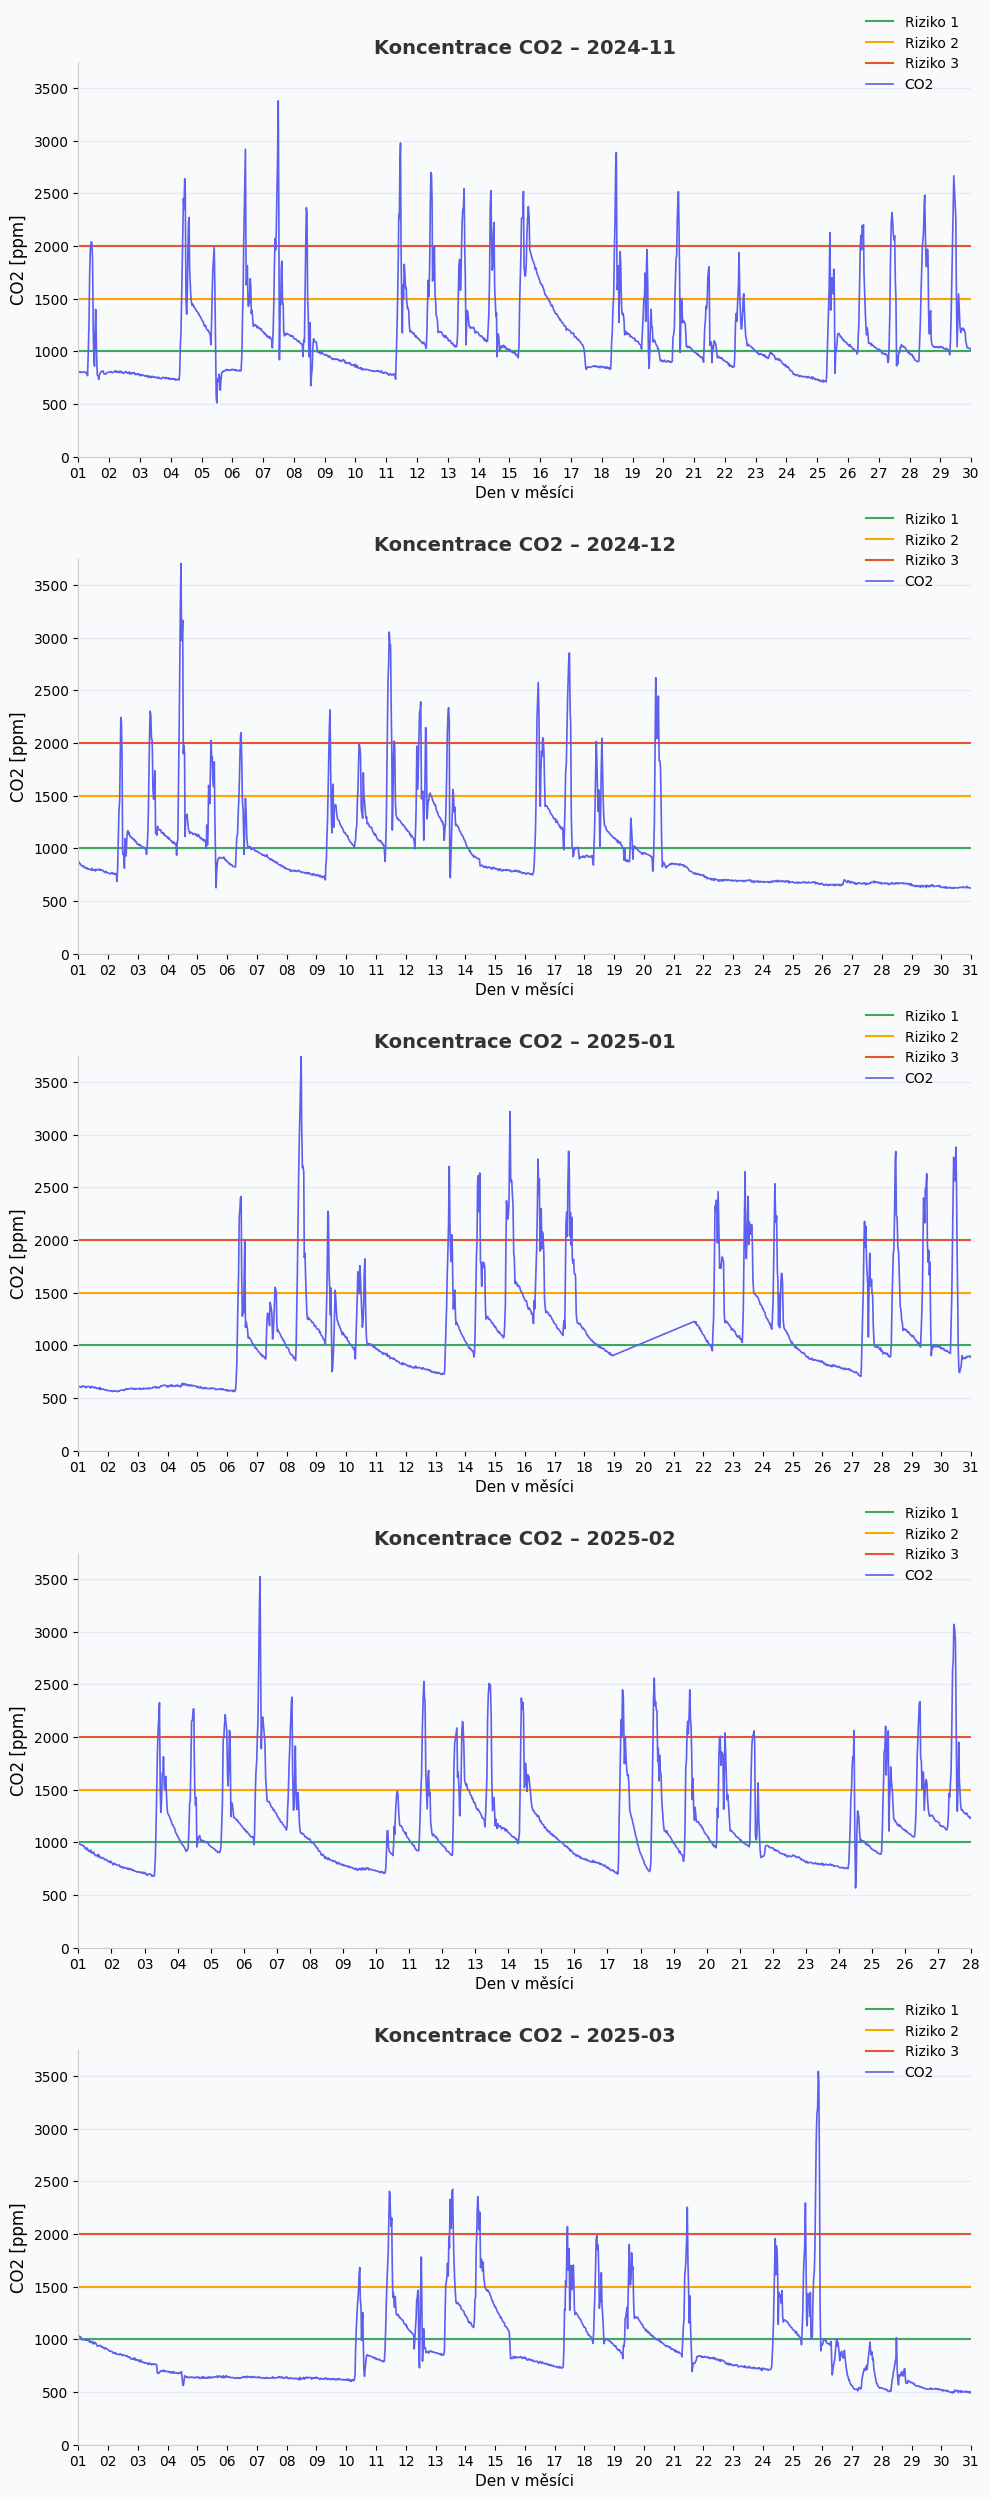

In [19]:
# Plotting the graph
fig_co2_01, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10, (5*n_vmouths)), sharey=True, facecolor=background_color)
axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

for i, one_month in enumerate(valid_months):
    df_month = class_df[class_df["month"] == one_month].copy()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Limits
    ax.axhline(y=co21, color=min_line_color, linestyle="-", linewidth=1.5, label="Riziko 1")
    ax.axhline(y=co22, color="orange", linestyle="-", linewidth=1.5, label="Riziko 2")
    ax.axhline(y=co23, color=max_line_color, linestyle="-", linewidth=1.5, label="Riziko 3")

    # Time series
    ax.plot(df_month["temp_sensor_time"], df_month["co2_avg"],
            label="CO2", color=line_color, linewidth=1.2)

    # Titles and axis
    ax.set_title(f"Koncentrace CO2 – {one_month}", fontsize=14, weight='bold', color="#333333")
    ax.set_ylabel("CO2 [ppm]", fontsize=12)
    ax.set_xlabel("Den v měsíci", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # X-axis format
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))

    # Cut X axis
    one_month_str = str(one_month)
    xmin = pd.to_datetime(f"{one_month_str}-01")
    xmax = xmin + pd.offsets.MonthEnd(0)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(0, 3750)

    # Grid and borders
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_co2_01)

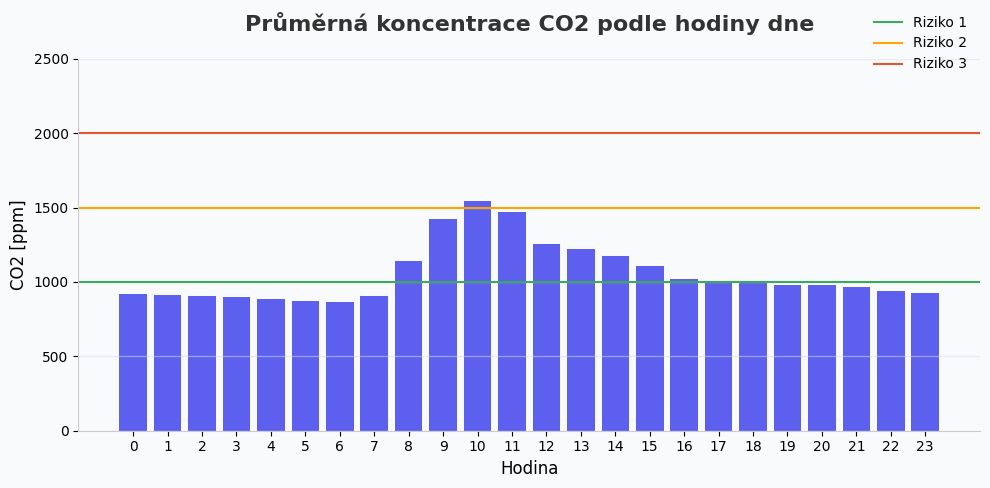

In [20]:
# Calculation of average temperature by hour
hourly_avg = class_df.groupby("hour")["co2_avg"].mean()

# Plotting the graph
fig_co2_02, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Columns
ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

# Limits
ax.axhline(y=co21, color=min_line_color, linestyle="-", linewidth=1.5, label="Riziko 1")
ax.axhline(y=co22, color="orange", linestyle="-", linewidth=1.5, label="Riziko 2")
ax.axhline(y=co23, color=max_line_color, linestyle="-", linewidth=1.5, label="Riziko 3")

# Titles and axes
ax.set_title("Průměrná koncentrace CO2 podle hodiny dne", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Hodina", fontsize=12)
ax.set_ylabel("CO2 [ppm]", fontsize=12)
ax.set_xticks(range(0, 24))
ax.set_ylim(0, 2500)
ax.tick_params(axis='both', labelsize=10)

# Grid
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

# Frames and styling
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_co2_02)

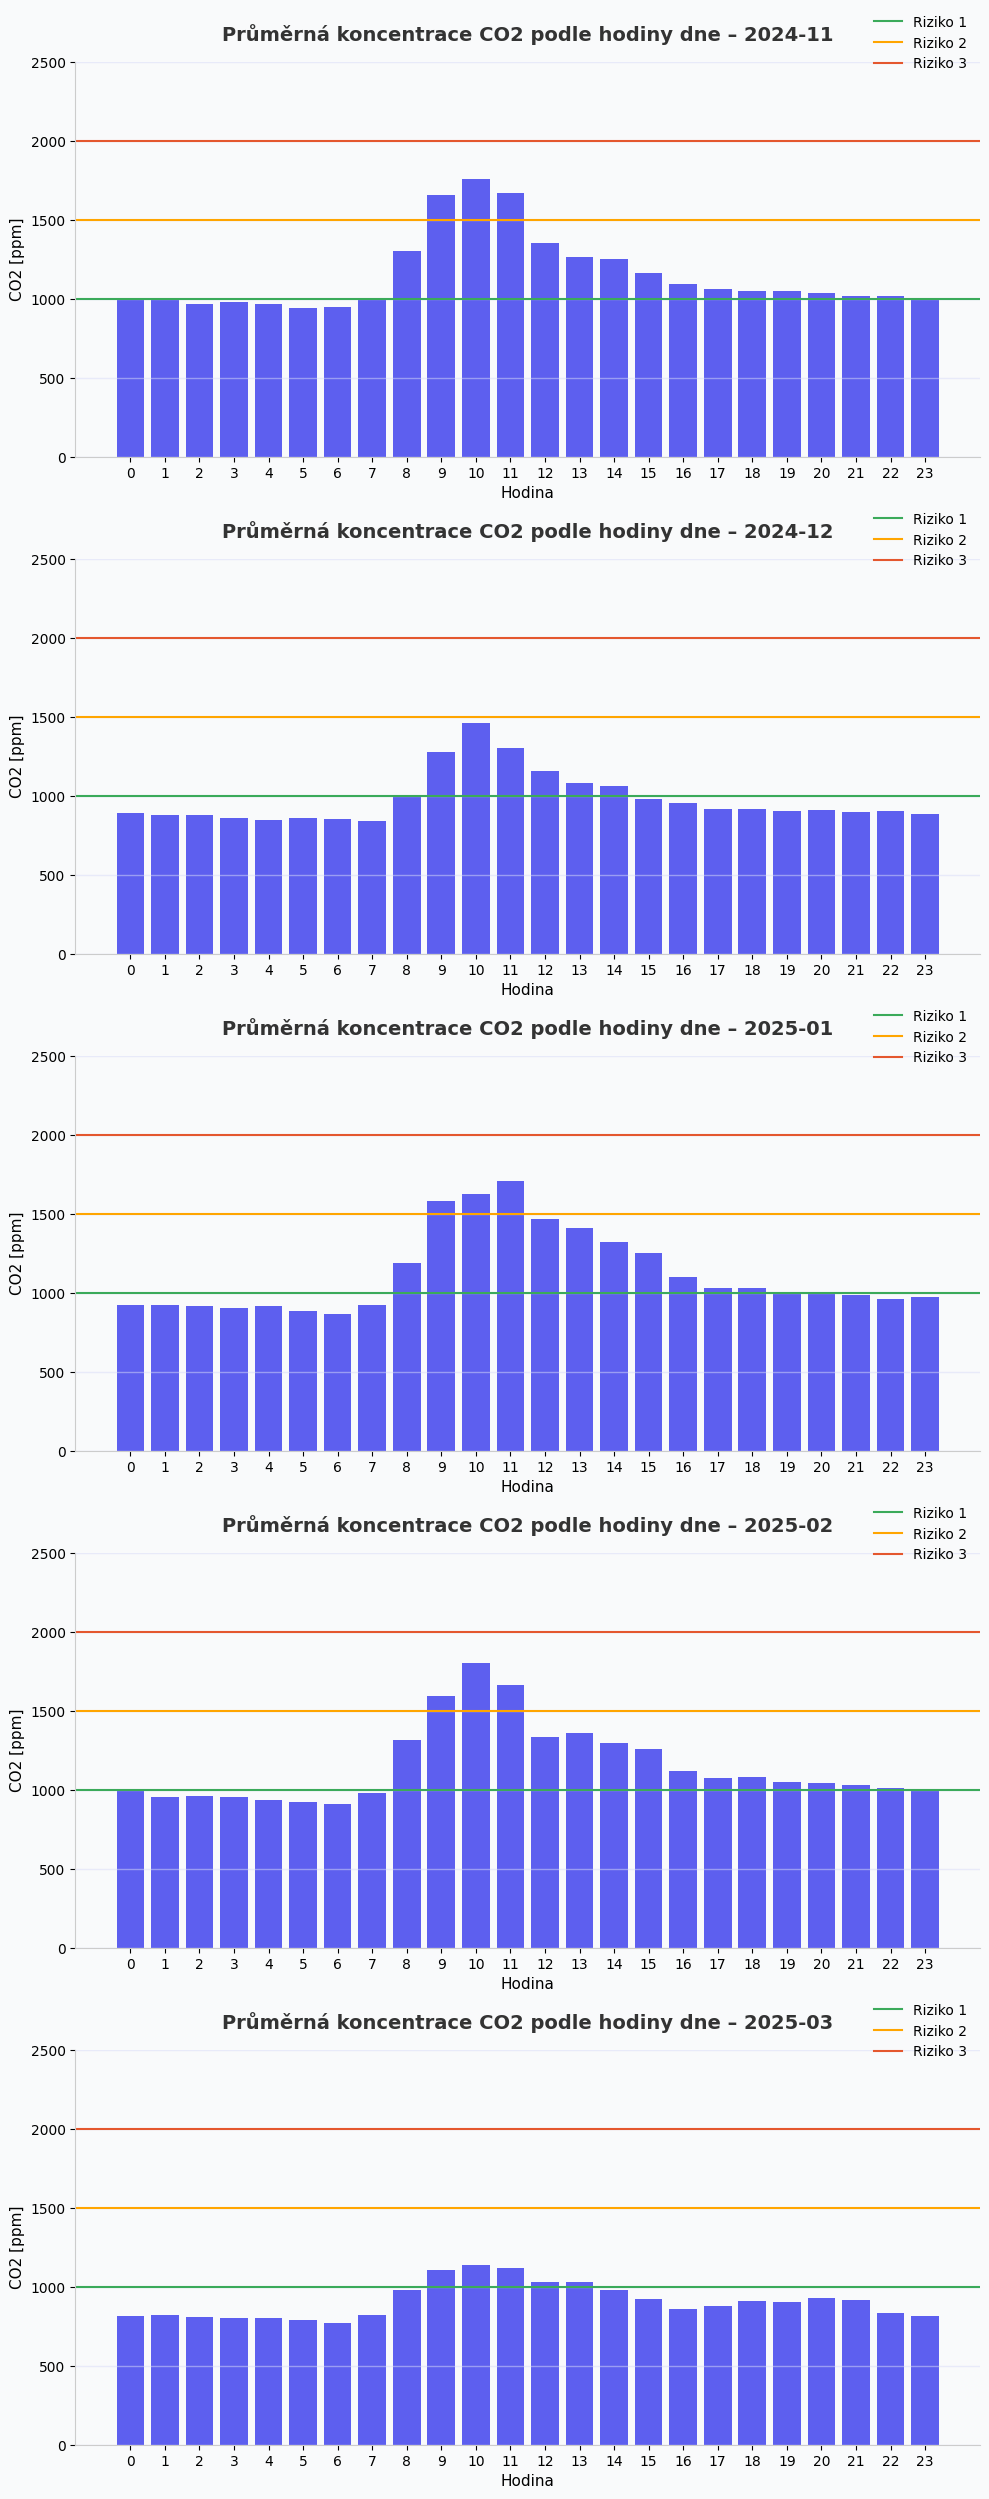

In [21]:
# Plotting the graph
fig_co2_03, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10,5*n_vmouths), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, one_month in enumerate(valid_months):
    df_month = class_df[class_df["month"] == one_month]
    hourly_avg = df_month.groupby("hour")["co2_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Columns
    ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

    # Limits
    ax.axhline(y=co21, color=min_line_color, linestyle="-", linewidth=1.5, label="Riziko 1")
    ax.axhline(y=co22, color="orange", linestyle="-", linewidth=1.5, label="Riziko 2")
    ax.axhline(y=co23, color=max_line_color, linestyle="-", linewidth=1.5, label="Riziko 3")

    # Titles and axes
    ax.set_title(f"Průměrná koncentrace CO2 podle hodiny dne – {one_month}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Hodina", fontsize=11)
    ax.set_ylabel("CO2 [ppm]", fontsize=11)
    ax.set_xticks(range(0, 24))
    ax.set_ylim(0, 2500)
    ax.tick_params(axis='both', labelsize=10)

    # Grid
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

    # Frames and styling
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_co2_03)

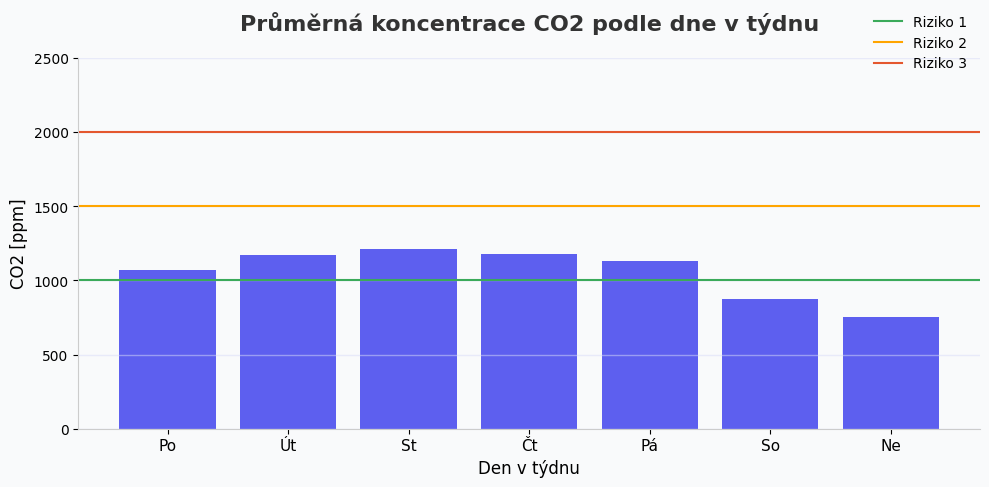

In [22]:
# Calculation of average temperature by day od the week
weekly_avg = class_df.groupby("dayofweek")["co2_avg"].mean()

# Plotting the graph
fig_co2_04, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Columns
ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

# Limits
ax.axhline(y=co21, color=min_line_color, linestyle="-", linewidth=1.5, label="Riziko 1")
ax.axhline(y=co22, color="orange", linestyle="-", linewidth=1.5, label="Riziko 2")
ax.axhline(y=co23, color=max_line_color, linestyle="-", linewidth=1.5, label="Riziko 3")

# Titles and axes
ax.set_title("Průměrná koncentrace CO2 podle dne v týdnu", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Den v týdnu", fontsize=12)
ax.set_ylabel("CO2 [ppm]", fontsize=12)
ax.set_xticks(range(7))
ax.set_xticklabels (nameofdays, fontsize=11)
ax.set_ylim(0, 2500)
ax.tick_params(axis='y', labelsize=10)

# Frames and styling
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_co2_04)

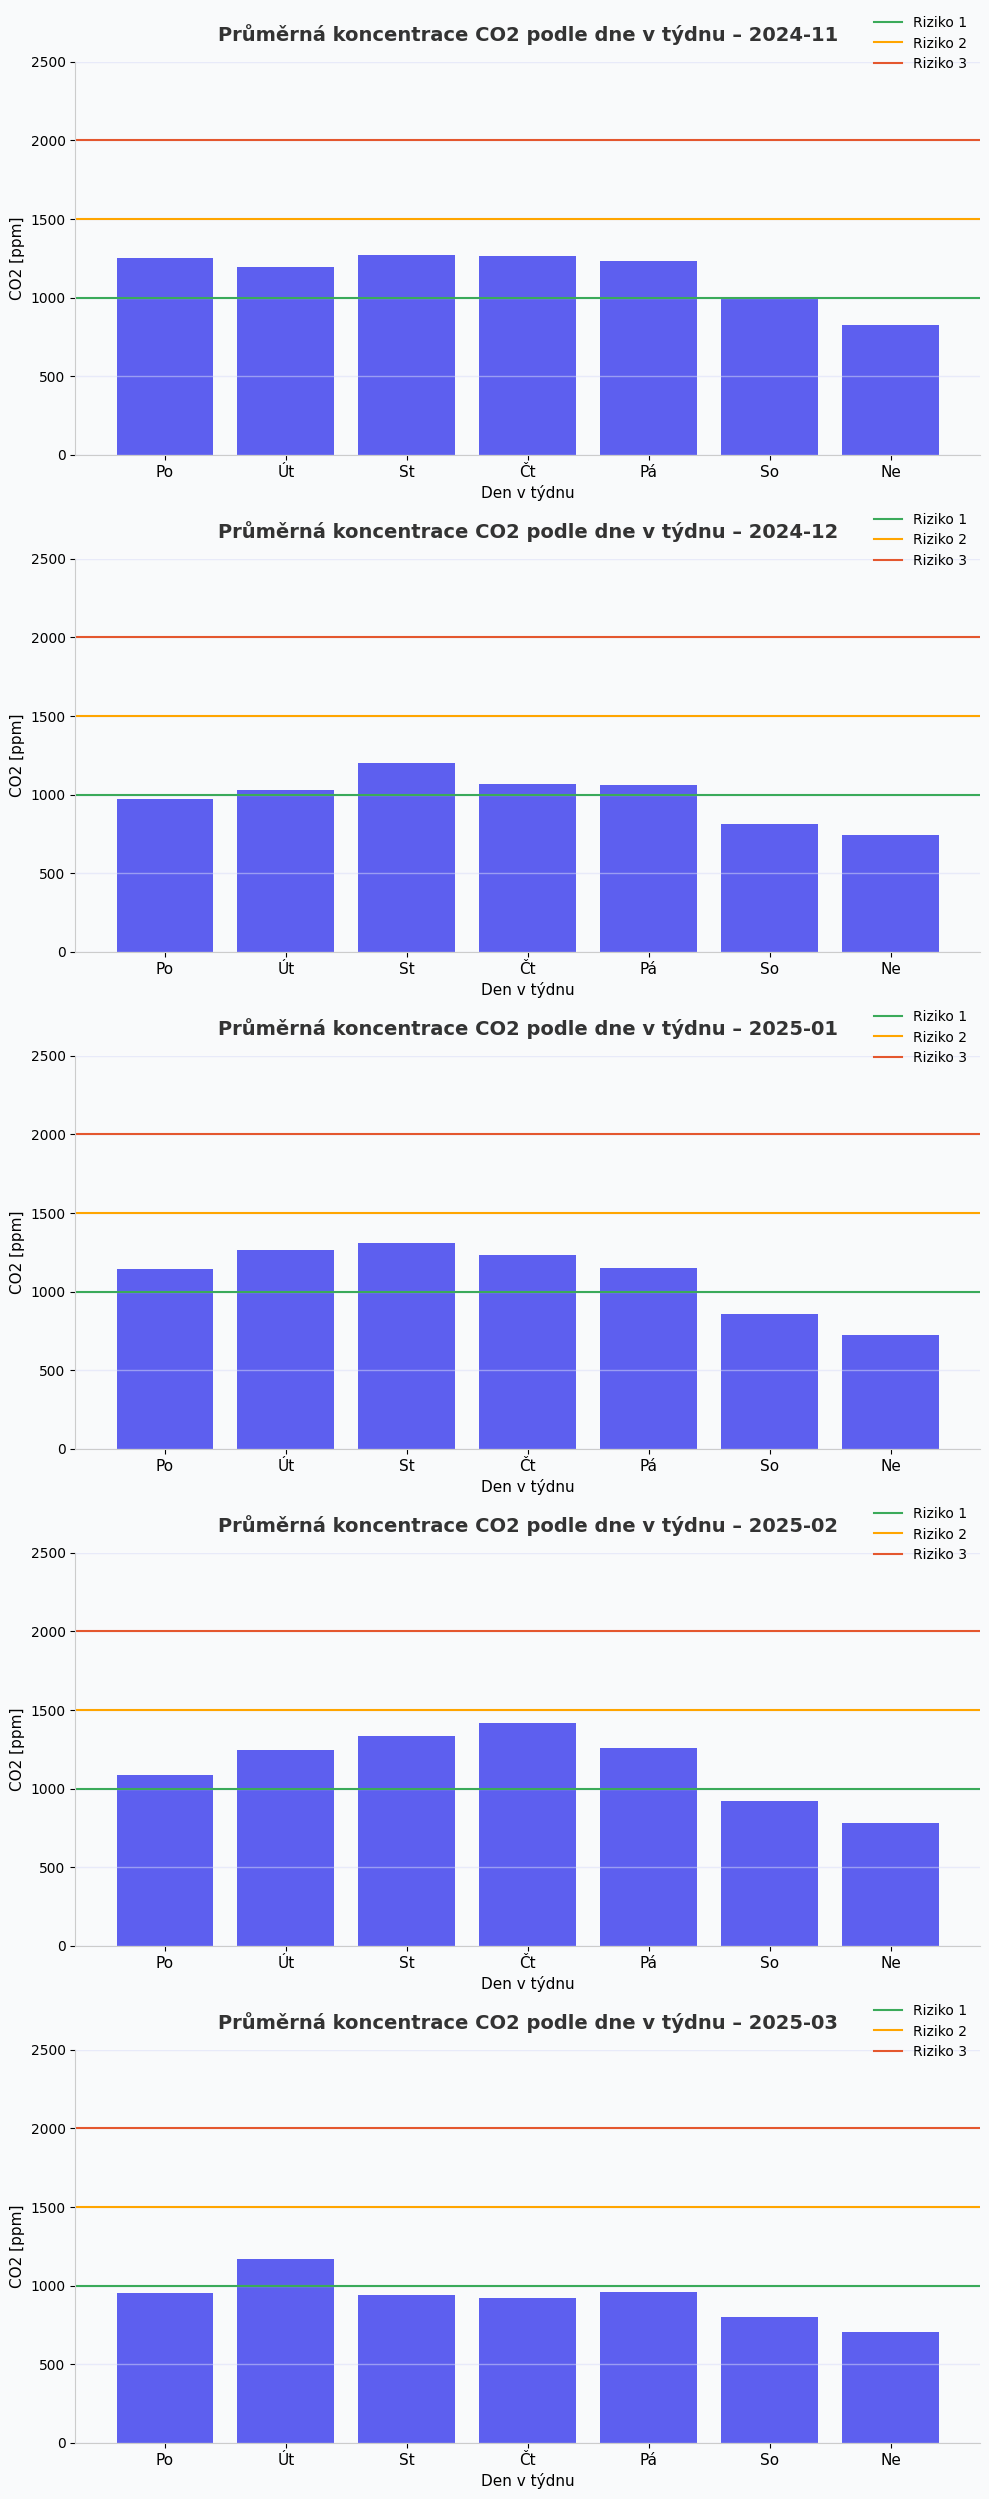

In [23]:
# Plotting the graph
fig_co2_05, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10, (5 * n_vmouths)), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, one_month in enumerate(valid_months):
    df_mesic = class_df[class_df["month"] == one_month]
    weekly_avg = df_mesic.groupby("dayofweek")["co2_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Columns
    ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

    # Limits
    ax.axhline(y=co21, color=min_line_color, linestyle="-", linewidth=1.5, label="Riziko 1")
    ax.axhline(y=co22, color="orange", linestyle="-", linewidth=1.5, label="Riziko 2")
    ax.axhline(y=co23, color=max_line_color, linestyle="-", linewidth=1.5, label="Riziko 3")

    # Titles and axes
    ax.set_title(f"Průměrná koncentrace CO2 podle dne v týdnu – {one_month}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Den v týdnu", fontsize=11)
    ax.set_ylabel("CO2 [ppm]", fontsize=11)
    ax.set_xticks(range(7))
    ax.set_xticklabels(nameofdays, fontsize=11)
    ax.set_ylim(0, 2500)
    ax.tick_params(axis='y', labelsize=10)

    # Frames and styling
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_co2_05)

Pressure

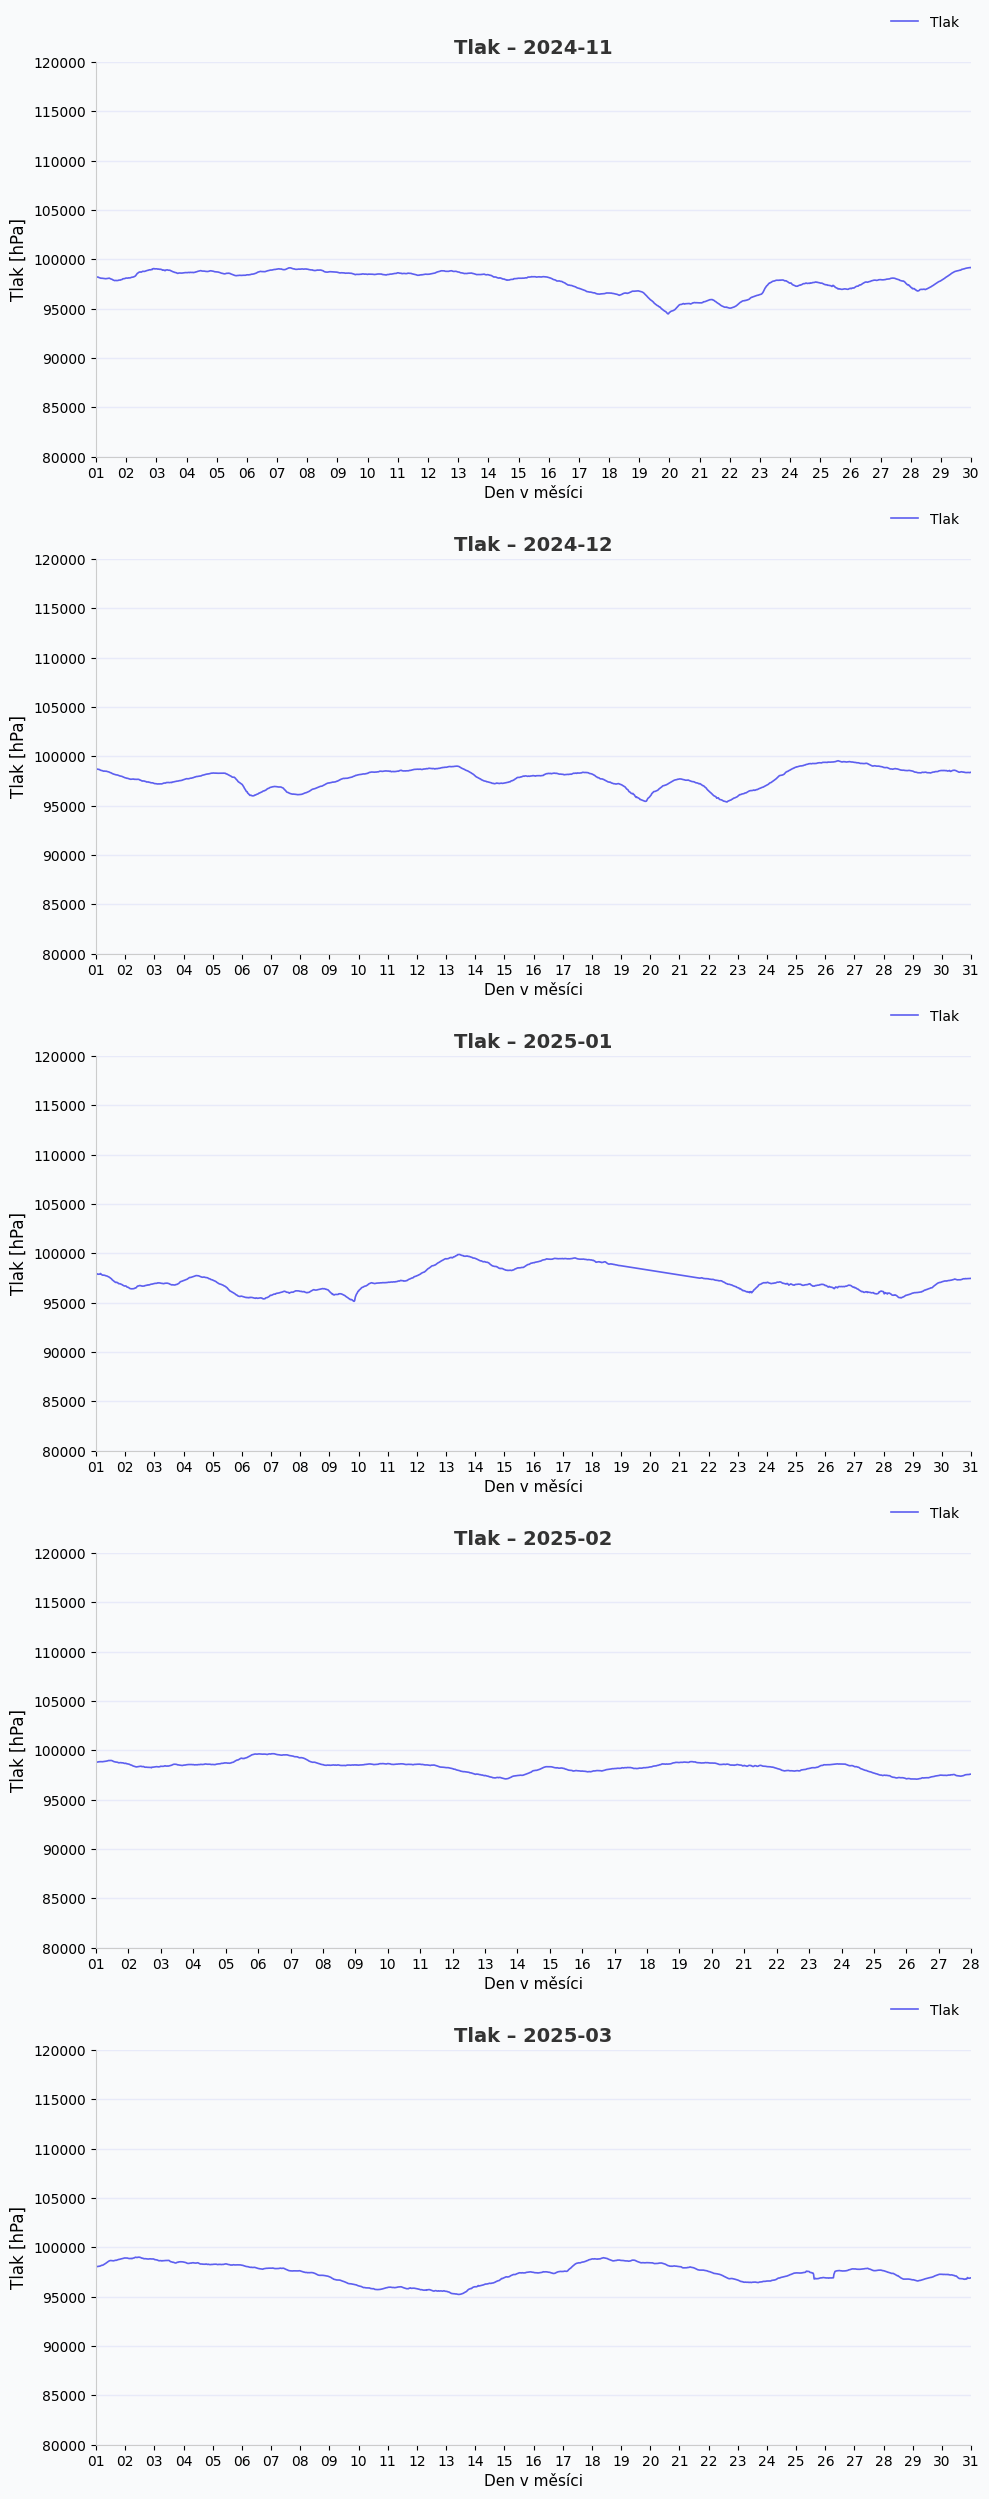

In [24]:
# Plotting the graph
fig_press_01, axes = plt.subplots(nrows=n_vmouths, ncols=1, figsize=(10, (5*n_vmouths)), sharey=True, facecolor=background_color)
axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

for i, one_month in enumerate(valid_months):
    df_month = class_df[class_df["month"] == one_month].copy()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Time series
    ax.plot(df_month["temp_sensor_time"], df_month["pressure_avg"],
            label="Tlak", color=line_color, linewidth=1.2)

    # Titles and axis
    ax.set_title(f"Tlak – {one_month}", fontsize=14, weight='bold', color="#333333")
    ax.set_ylabel("Tlak [hPa]", fontsize=12)
    ax.set_xlabel("Den v měsíci", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # X-axis format
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))

    # Cut X axis
    one_month_str = str(one_month)
    xmin = pd.to_datetime(f"{one_month_str}-01")
    xmax = xmin + pd.offsets.MonthEnd(0)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(80000, 120000)

    # Grid and borders
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_press_01)

In [25]:
# Downloading charts to a folder
output_dir = "3_trida_grafy"
os.makedirs(output_dir, exist_ok=True)

grafy = {
    "temp_01.png" : fig_temp_01,
    "temp_02.png" : fig_temp_02,
    "temp_03.png" : fig_temp_03,
    "temp_04.png" : fig_temp_04,
    "temp_05.png" : fig_temp_05,

    "humi_01.png" : fig_humi_01,
    "humi_02.png" : fig_humi_02,
    "humi_03.png" : fig_humi_03,
    "humi_04.png" : fig_humi_04,
    "humi_05.png" : fig_humi_05,

    "co2_01.png": fig_co2_01,
    "co2_02.png": fig_co2_02,
    "co2_03.png": fig_co2_03,
    "co2_04.png": fig_co2_04,
    "co2_05.png": fig_co2_05,

    "press_01.png": fig_press_01
}

for name, fig in grafy.items():
    fig.savefig(os.path.join(output_dir, name), dpi=200)